In [1]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns;

%matplotlib inline

pd.options.display.max_columns = None


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load experiment Design data

## 1. Load Email list

In [3]:
# hard code Email lists. Email ID is the index of the Email in the list

PO_number_list = ['ml_funding_enables_investing','ml_investing_starts_here','ml_explore_the_app_investing',
                  'ml_funding_faq','ml_user_clustering_emails_fracs','ml_funding_is_safe','ml_picking_an_investment', 
                  'ml_investing_101','ml_diversified_portfolio','ml_explore_the_app_list']

## 2. Load user segment information

In [4]:
segment_group_init_df = pd.read_csv('/content/drive/MyDrive/直通硅谷/大班教案/Projects/project-Email/data/sample_segment_groups.csv')
segment_group_init_df = segment_group_init_df.drop(columns='Unnamed: 0')
segment_group_init_df.head(20)

,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid,group_name
0,0,False,False,False,False,4418550,ML_unfund_exp_control
1,1,False,False,True,False,314921,20D_Act
2,2,False,False,True,True,409786,20D_Act-5D_Act
3,3,False,True,False,False,941341,link
4,4,False,True,True,False,102541,link-20D_Act
5,5,False,True,True,True,136513,link-20D_Act-5D_Act
6,6,True,False,False,False,814827,6M_App
7,7,True,False,True,False,218938,6M_App-20D_Act
8,8,True,False,True,True,233445,6M_App-20D_Act-5D_Act
9,9,True,True,False,False,127008,6M_App-link


## 3. Load sampled users with Email delivery orders for the experiment

In [5]:
sample_exp_df = pd.read_csv('/content/drive/MyDrive/直通硅谷/大班教案/Projects/project-Email/data/sample_uuid_email_order.csv')
sample_exp_df.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,5,7,3,4,8,9,0,1,6,2
1,id_14752263936159847779,0,ML_unfund_exp_control_D,3,1,6,0,5,9,4,8,7,2
2,id_3723259155072282145,0,ML_unfund_exp_control_D,8,7,3,6,1,4,2,9,0,5
3,id_9433964625840258739,0,ML_unfund_exp_control_D,1,8,0,6,5,7,4,9,3,2
4,id_17251718038176858460,0,ML_unfund_exp_control_D,6,1,8,0,7,3,5,2,9,4


In [6]:
sample_exp_df.shape

(480000, 13)

# load Email Events

In [7]:
email_event_summary_df = pd.read_csv('/content/drive/MyDrive/直通硅谷/大班教案/Projects/project-Email/data/email_events.csv')

In [8]:
email_event_summary_df.head()

,stitch_email_events.category,stitch_email_events.dt_date,user_uuid,event,reason,stitch_email_events.count_events
0,"[""ml_picking_an_investment"",""post-office""]",2020-12-30,id_13999943483500367320,open,NaN,1
1,"[""ml_explore_the_app_investing"",""post-office""]",2020-12-30,id_3965698071238241409,open,NaN,1
2,"[""ml_picking_an_investment"",""post-office""]",2020-12-30,id_9648414115970654735,open,NaN,1
3,"[""ml_investing_starts_here"",""post-office""]",2020-12-30,id_8951454012305223869,open,NaN,1
4,"[""ml_investing_101"",""post-office""]",2020-12-30,id_8180145303883056882,open,NaN,2


In [9]:
email_event_summary_df['event'].unique()

array(['open', 'unsubscribe', 'spamreport', 'deferred', 'bounce',
       'processed', 'delivered', 'dropped'], dtype=object)

# load current user status

In [10]:
user_event_df = pd.read_csv('/content/drive/MyDrive/直通硅谷/大班教案/Projects/project-Email/data/user_events.csv')
user_event_df.head()

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,approved_at,first_funded_at,first_linked_bank_account_at,5d_trading_avg_event_count,2d_non_trading_avg_event_count,20d_trading_avg_event_count,8d_non_trading_avg_event_count,1d_trading_avg_event_count,1d_non_trading_avg_event_count,num_received_email
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-14 16:31:59.295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered,2019-01-29 16:22:26.866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open,2019-02-01 00:01:48.853,2020-12-04 20:41:55.146,2020-12-04 20:41:37.842,53.0,NaN,171.0,NaN,NaN,NaN,6
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,2020-03-17 21:02:43.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30 18:23:15.726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# Calculate Metrics for treatment groups


## 1. Email open rate

In [11]:
delivered_count_df = user_event_df[['user_uuid','group_name']+PO_number_list]
for e in PO_number_list:
    delivered_count_df[e] = delivered_count_df[e].notnull()
    
delivered_count_df = delivered_count_df.groupby('group_name').sum().reset_index()

<ipython-input-11-30f68b0b9d36>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_count_df[e] = delivered_count_df[e].notnull()
<ipython-input-11-30f68b0b9d36>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  delivered_count_df = delivered_count_df.groupby('group_name').sum().reset_index()


In [12]:
delivered_count_df.head(50)

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,19230,19257,19252,19251,19253,19251,19271,19265,19241,19249
1,20D_Act-5D_Act_W,17412,17292,17346,17323,17299,17365,17319,17294,17347,17294
2,20D_Act_D,19062,19040,19054,19055,19060,19050,19056,19050,19052,19042
3,20D_Act_W,17202,17132,17148,17107,17052,17156,17108,17097,17156,17094
4,6M_App-20D_Act-5D_Act_D,19290,19285,19268,19289,19283,19285,19270,19282,19308,19273
5,6M_App-20D_Act-5D_Act_W,17409,17325,17383,17344,17305,17393,17357,17333,17377,17342
6,6M_App-20D_Act_D,19048,19037,19037,19050,19051,19041,19039,19052,19065,19031
7,6M_App-20D_Act_W,17205,17101,17113,17096,17046,17141,17118,17096,17150,17091
8,6M_App-link-20D_Act-5D_Act_D,19209,19211,19207,19198,19201,19208,19217,19205,19186,19181
9,6M_App-link-20D_Act-5D_Act_W,17251,17198,17190,17179,17158,17228,17183,17171,17218,17165


In [13]:
open_count_df = user_event_df[['user_uuid','group_name']+PO_number_list]
for e in PO_number_list:
    open_count_df[e] = open_count_df[e] == 'open' 
    
open_count_df = open_count_df.groupby('group_name').sum().reset_index()

<ipython-input-13-dc8aed60f802>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_count_df[e] = open_count_df[e] == 'open'
<ipython-input-13-dc8aed60f802>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  open_count_df = open_count_df.groupby('group_name').sum().reset_index()


In [14]:
open_count_df.head(50)

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,3191,3140,3171,5054,3407,3215,3306,3243,3043,3290
1,20D_Act-5D_Act_W,2873,2875,2843,4545,3117,2878,2924,2869,2829,2879
2,20D_Act_D,3464,3455,3487,5108,3650,3501,3545,3476,3524,3520
3,20D_Act_W,3022,3094,3058,4598,3146,3134,3084,3113,3010,3170
4,6M_App-20D_Act-5D_Act_D,3465,3493,3423,4896,3698,3486,3644,3520,3430,3590
5,6M_App-20D_Act-5D_Act_W,3187,3267,3147,4457,3355,3145,3213,3130,3095,3169
6,6M_App-20D_Act_D,3552,3658,3650,4786,3826,3651,3817,3658,3527,3677
7,6M_App-20D_Act_W,3114,3126,3091,4348,3284,3117,3151,3178,3137,3178
8,6M_App-link-20D_Act-5D_Act_D,3899,3876,3931,6054,4133,3943,3918,3913,3796,3896
9,6M_App-link-20D_Act-5D_Act_W,3390,3389,3358,5419,3505,3432,3482,3428,3263,3418


In [15]:
open_rate_df = open_count_df
for e in PO_number_list:
    open_rate_df[e] = open_count_df[e]/delivered_count_df[e]

In [16]:
open_rate_df.head(50)

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,0.165939,0.163058,0.164710,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918
1,20D_Act-5D_Act_W,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474
2,20D_Act_D,0.181723,0.181460,0.183006,0.268066,0.191501,0.183780,0.186031,0.182467,0.184967,0.184855
3,20D_Act_W,0.175677,0.180598,0.178330,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445
4,6M_App-20D_Act-5D_Act_D,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271
5,6M_App-20D_Act-5D_Act_W,0.183066,0.188571,0.181039,0.256976,0.193875,0.180820,0.185113,0.180580,0.178109,0.182736
6,6M_App-20D_Act_D,0.186476,0.192152,0.191732,0.251234,0.200829,0.191744,0.200483,0.192001,0.184999,0.193211
7,6M_App-20D_Act_W,0.180994,0.182796,0.180623,0.254328,0.192655,0.181845,0.184075,0.185891,0.182915,0.185946
8,6M_App-link-20D_Act-5D_Act_D,0.202978,0.201759,0.204665,0.315345,0.215249,0.205279,0.203882,0.203749,0.197853,0.203118
9,6M_App-link-20D_Act-5D_Act_W,0.196510,0.197058,0.195346,0.315443,0.204278,0.199211,0.202642,0.199639,0.189511,0.199126


### From the open rate heatmap, we can clearly see the most effective Email is 'ml_funding_faq'. The best user segment group is '6M_App-link-20D_Act-5D_Act_*'

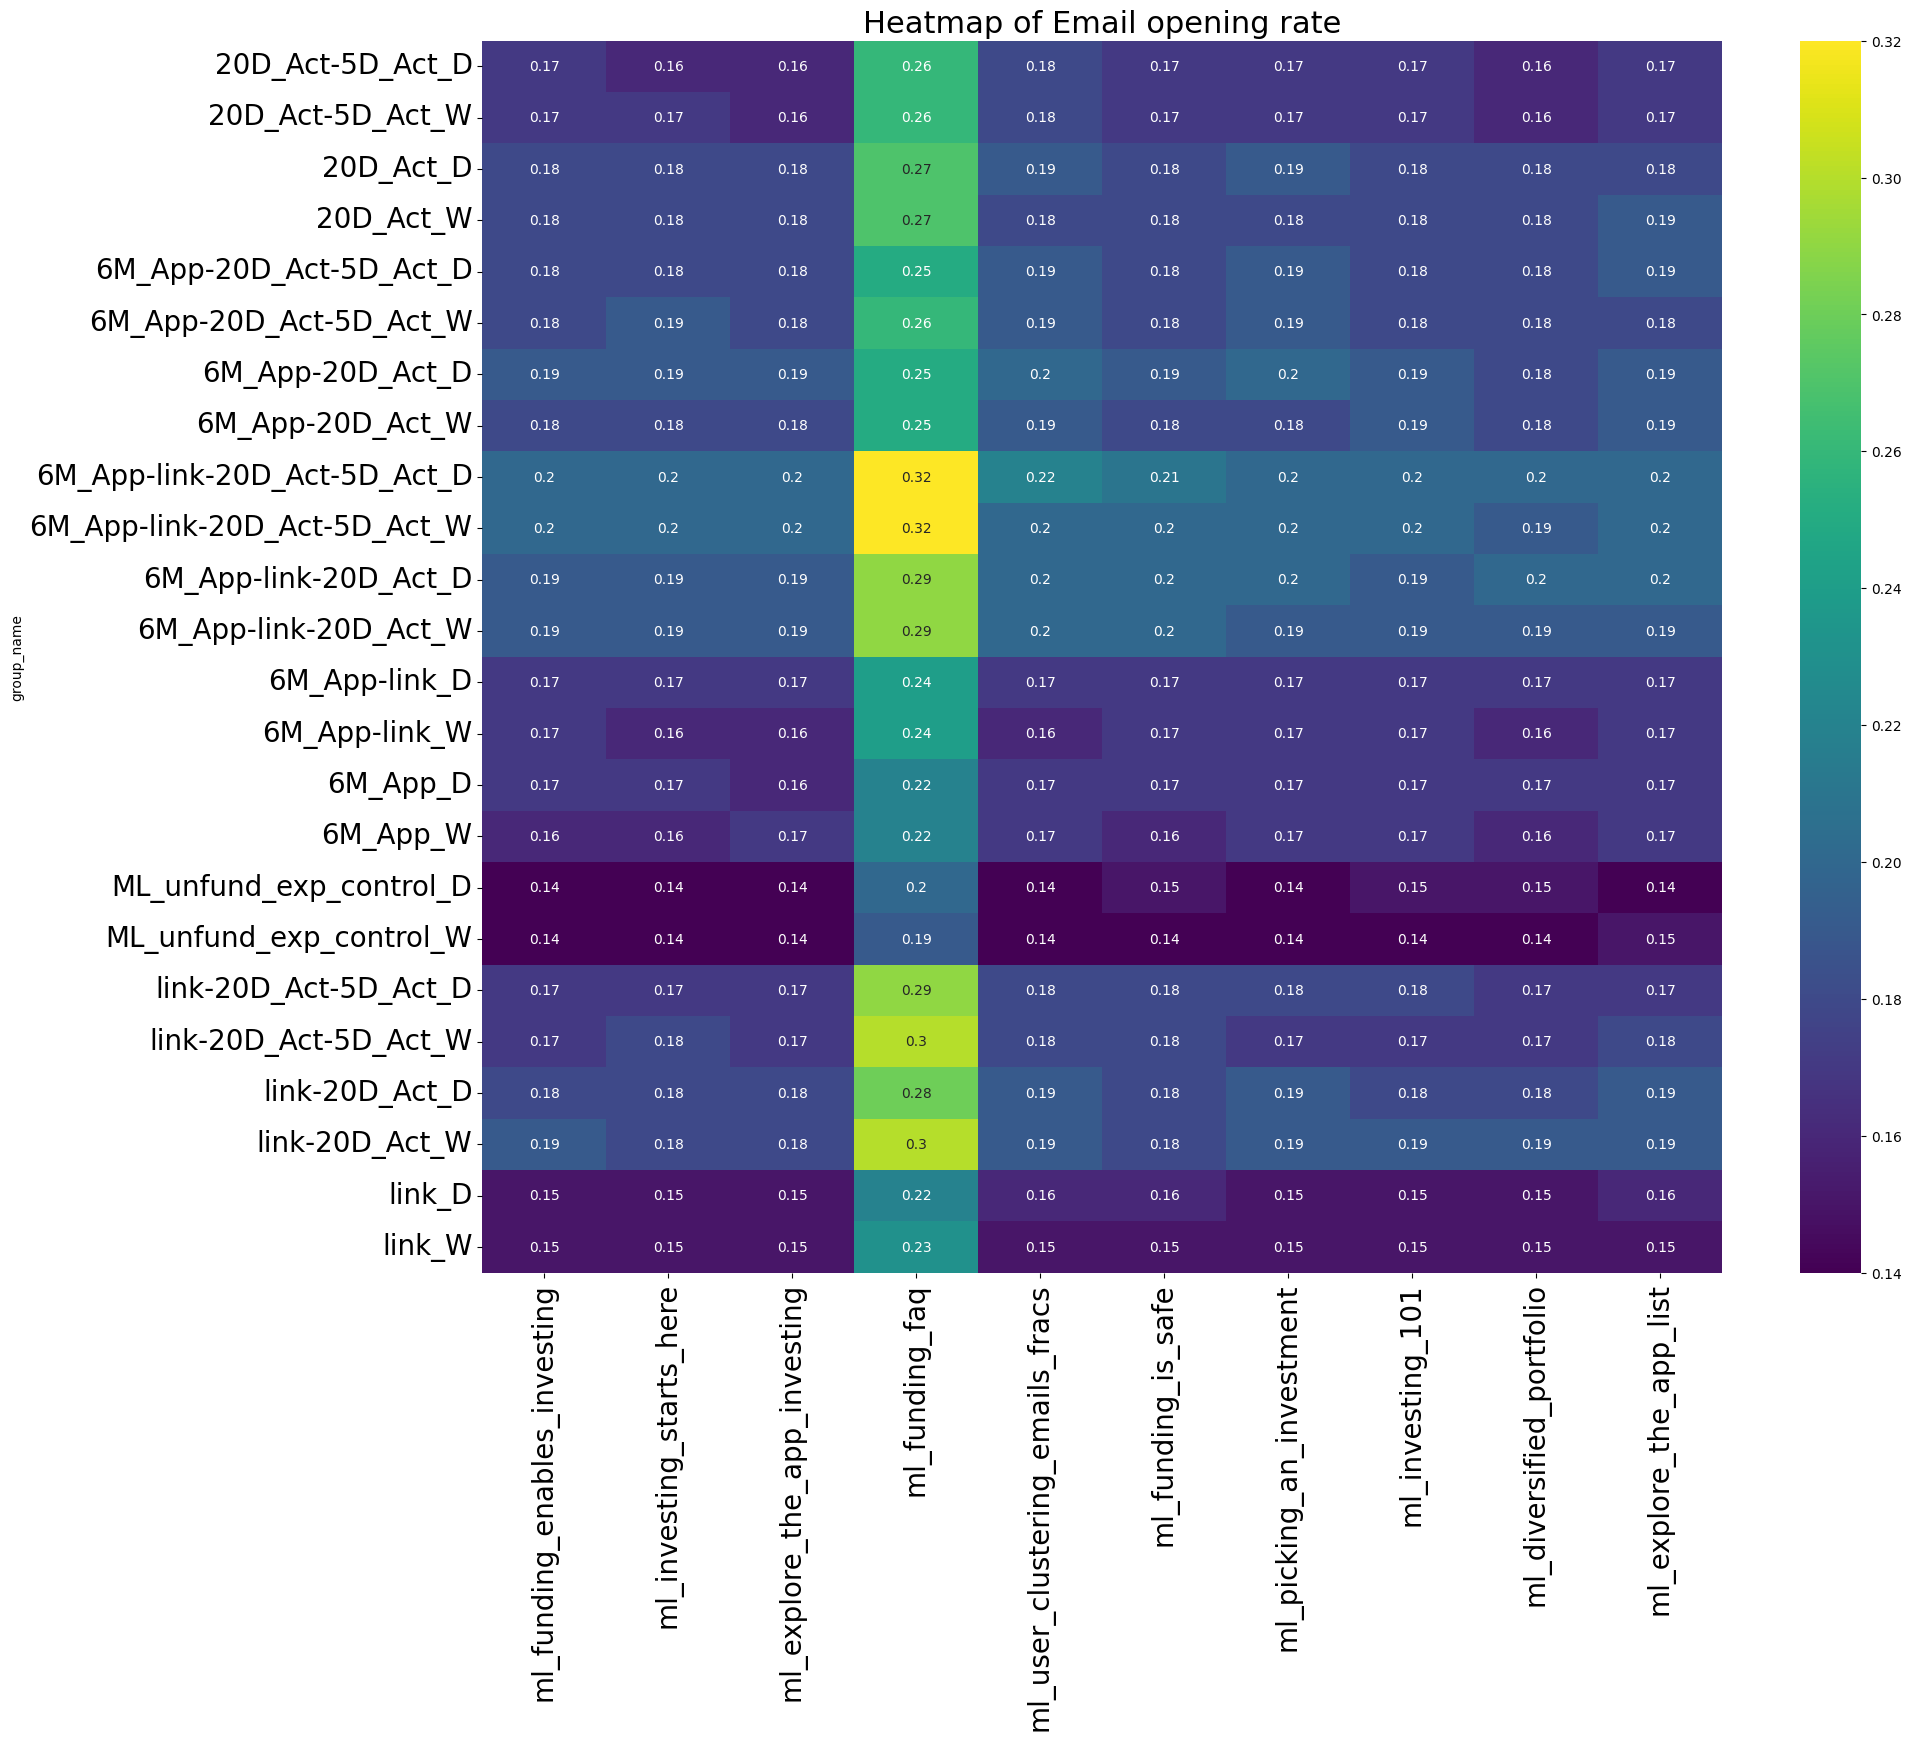

In [17]:
result = open_rate_df.round(2).set_index('group_name')
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Heatmap of Email opening rate',fontsize=22)
    
    
plt.show()

### Optional: check negative effects, such as 'report spam', 'unsubscribe'. Events such as closing account can be tracked in user activity table.

In [18]:
#neg_count_df = user_event_df.drop(columns=['user_uuid'])
neg_count_df = user_event_df[['user_uuid','group_name']+PO_number_list]
for e in PO_number_list:
    neg_count_df[e] = ((neg_count_df[e] == 'spamreport') | (neg_count_df[e] == 'unsubscribe'))
    
neg_count_df = neg_count_df.groupby('group_name').sum().reset_index()

<ipython-input-18-e3cf2f875470>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_count_df[e] = ((neg_count_df[e] == 'spamreport') | (neg_count_df[e] == 'unsubscribe'))
<ipython-input-18-e3cf2f875470>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  neg_count_df = neg_count_df.groupby('group_name').sum().reset_index()


In [19]:
neg_count_df.head(50)

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,20D_Act-5D_Act_D,2,7,5,7,8,3,11,10,9,8
1,20D_Act-5D_Act_W,2,3,1,7,5,3,1,1,5,2
2,20D_Act_D,4,4,1,5,9,8,9,4,6,7
3,20D_Act_W,7,3,3,3,5,4,2,5,6,1
4,6M_App-20D_Act-5D_Act_D,5,4,3,4,7,4,4,3,3,5
5,6M_App-20D_Act-5D_Act_W,4,5,5,4,5,4,4,6,3,5
6,6M_App-20D_Act_D,4,4,8,5,6,6,4,4,10,2
7,6M_App-20D_Act_W,4,4,7,4,6,6,3,5,4,8
8,6M_App-link-20D_Act-5D_Act_D,10,6,7,6,8,4,8,6,14,9
9,6M_App-link-20D_Act-5D_Act_W,3,3,4,4,5,4,3,5,4,7


## 2. Correlation analysis on open rate

In [20]:
open_rate_flat_df = open_rate_df.copy()
open_rate_flat_df['daily'] = open_rate_flat_df['group_name'].str.contains('_D')
open_rate_flat_df['twice_a_week'] = open_rate_flat_df['group_name'].str.contains('_W')
open_rate_flat_df['group_name'] = open_rate_flat_df['group_name'].str.strip('_D')
open_rate_flat_df['group_name'] = open_rate_flat_df['group_name'].str.strip('_W')

open_rate_flat_df = open_rate_flat_df.merge(segment_group_init_df,how = 'left',on='group_name')
open_rate_flat_df.head()



,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,daily,twice_a_week,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid
0,20D_Act-5D_Act,0.165939,0.163058,0.164710,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918,True,False,2,False,False,True,True,409786
1,20D_Act-5D_Act,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474,False,True,2,False,False,True,True,409786
2,20D_Act,0.181723,0.181460,0.183006,0.268066,0.191501,0.183780,0.186031,0.182467,0.184967,0.184855,True,False,1,False,False,True,False,314921
3,20D_Act,0.175677,0.180598,0.178330,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445,False,True,1,False,False,True,False,314921
4,6M_App-20D_Act-5D_Act,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271,True,False,8,True,False,True,True,233445


In [21]:
open_rate_flat_template_df = open_rate_flat_df.copy()
open_rate_flat_template_df[PO_number_list] = False

open_rate_flat_TF_df = pd.DataFrame()
for e in PO_number_list:
    temp = open_rate_flat_template_df.copy()
    temp[e] = True
    temp['open_rate'] = open_rate_flat_df[e]
    open_rate_flat_TF_df = pd.concat([open_rate_flat_TF_df, temp])

open_rate_flat_TF_df = open_rate_flat_TF_df.reset_index()
open_rate_flat_TF_df = open_rate_flat_TF_df.drop(columns = ['index'])
open_rate_flat_TF_df.head(100)

,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,daily,twice_a_week,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid,open_rate
0,20D_Act-5D_Act,True,False,False,False,False,False,False,False,False,False,True,False,2,False,False,True,True,409786,0.165939
1,20D_Act-5D_Act,True,False,False,False,False,False,False,False,False,False,False,True,2,False,False,True,True,409786,0.165001
2,20D_Act,True,False,False,False,False,False,False,False,False,False,True,False,1,False,False,True,False,314921,0.181723
3,20D_Act,True,False,False,False,False,False,False,False,False,False,False,True,1,False,False,True,False,314921,0.175677
4,6M_App-20D_Act-5D_Act,True,False,False,False,False,False,False,False,False,False,True,False,8,True,False,True,True,233445,0.179627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,link,False,False,False,True,False,False,False,False,False,False,False,True,3,False,True,False,False,941341,0.225067
96,20D_Act-5D_Act,False,False,False,False,True,False,False,False,False,False,True,False,2,False,False,True,True,409786,0.176959
97,20D_Act-5D_Act,False,False,False,False,True,False,False,False,False,False,False,True,2,False,False,True,True,409786,0.180184
98,20D_Act,False,False,False,False,True,False,False,False,False,False,True,False,1,False,False,True,False,314921,0.191501


In [22]:
corr = open_rate_flat_TF_df.corr()

corr = corr.sort_values(by=['open_rate'], ascending =False)
corr['open_rate']

<ipython-input-22-717781328404>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = open_rate_flat_TF_df.corr()


open_rate                          1.000000
ml_funding_faq                     0.793531
recent_activity_flag(20days)       0.450146
group_id                           0.364588
approved_within6M_flag             0.241516
5day_trade_flag                    0.172443
link_flag                          0.160358
daily                              0.026641
ml_user_clustering_emails_fracs   -0.025562
twice_a_week                      -0.026641
ml_picking_an_investment          -0.065907
ml_explore_the_app_list           -0.074458
ml_funding_is_safe                -0.082867
ml_investing_101                  -0.090776
ml_investing_starts_here          -0.098976
ml_funding_enables_investing      -0.114963
ml_explore_the_app_investing      -0.117040
ml_diversified_portfolio          -0.122984
user_uuid                         -0.413757
Name: open_rate, dtype: float64

## 3. Link, activity and funding rates for treatment groups 

In [23]:
fund_exp_df = user_event_df[user_event_df['num_received_email']>0].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df = fund_exp_df.rename(columns = {'user_uuid':'num_users_received_email'})

# funding rate 
temp = user_event_df[user_event_df['first_funded_at'].notnull()].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df['num_funded'] = temp['user_uuid']
fund_exp_df['funding_rate'] = fund_exp_df['num_funded'] /fund_exp_df['num_users_received_email'] 

# link rate
temp = user_event_df[user_event_df['first_linked_bank_account_at'].notnull()].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df['num_link'] = temp['user_uuid']
fund_exp_df['link_rate'] = fund_exp_df['num_link'] /fund_exp_df['num_users_received_email'] 
fund_exp_df.loc[fund_exp_df['link_rate']>1,'link_rate'] = 1

# activity rate
act_list = []
for a in user_event_df.columns:
    if '_event_count' in a:
        act_list.append(a)
        
temp = user_event_df[user_event_df[act_list].sum(axis=1)>0].groupby('group_name')['user_uuid'].count().reset_index()
fund_exp_df['num_act'] = temp['user_uuid']
fund_exp_df['act_rate'] = fund_exp_df['num_act'] /fund_exp_df['num_users_received_email'] 
fund_exp_df.loc[fund_exp_df['act_rate']>1,'act_rate'] = 1

fund_exp_df.head(50)

,group_name,num_users_received_email,num_funded,funding_rate,num_link,link_rate,num_act,act_rate
0,20D_Act-5D_Act_D,18918,451,0.023840,586,0.030976,20000,1.000000
1,20D_Act-5D_Act_W,18966,450,0.023727,555,0.029263,20000,1.000000
2,20D_Act_D,18606,357,0.019187,460,0.024723,11135,0.598463
3,20D_Act_W,18711,310,0.016568,395,0.021111,11091,0.592753
4,6M_App-20D_Act-5D_Act_D,18927,1259,0.066519,1465,0.077403,20000,1.000000
5,6M_App-20D_Act-5D_Act_W,19066,1252,0.065667,1454,0.076261,20000,1.000000
6,6M_App-20D_Act_D,18646,690,0.037005,792,0.042476,9716,0.521077
7,6M_App-20D_Act_W,18752,644,0.034343,759,0.040476,9795,0.522344
8,6M_App-link-20D_Act-5D_Act_D,18799,2143,0.113995,20000,1.000000,20000,1.000000
9,6M_App-link-20D_Act-5D_Act_W,18888,2114,0.111923,20000,1.000000,20000,1.000000


In [24]:
print('overall funding rate: ')
print(fund_exp_df['num_funded'].sum() /fund_exp_df['num_users_received_email'].sum())

overall funding rate: 
0.03442991255931208


# Load the current status for control groups.

Thay have the same sagmentation rules in the beginning of the experiment.  
These users did not received any Emails during the experiment.

In [25]:
fund_control_df = pd.read_csv('/content/drive/MyDrive/直通硅谷/大班教案/Projects/project-Email/data/control_groups_rate.csv')
fund_control_df.head()

,group_name,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control
0,20D_Act-5D_Act_D,369786,7802,0.021099,9899,0.026770
1,20D_Act_D,274921,4053,0.014742,5143,0.018707
2,6M_App-20D_Act-5D_Act_D,193445,11556,0.059738,13396,0.069250
3,6M_App-20D_Act_D,178938,5636,0.031497,6570,0.036717
4,6M_App-link-20D_Act-5D_Act_D,29697,3047,0.102603,29697,1.000000


# A/B test on Treatment and Control groups.

Steps:
1. Merge treatment and control for funding rate  
2. Null hypothesis: funding rate (treatment) = funding rate (control)
3. Alternative hypothesis: funding rate (treatment) > funding rate (control)
4. Method: One sample proportional Z test.

In [26]:
exp_funding_merge_df = fund_exp_df.merge(fund_control_df,how = 'left', on = 'group_name')
exp_funding_merge_df = exp_funding_merge_df.fillna(method='ffill')

exp_funding_merge_df['delta_fund_rate'] = exp_funding_merge_df['funding_rate'] - exp_funding_merge_df['funding_rate_in_control'] 
exp_funding_merge_df['delta_link_rate'] = exp_funding_merge_df['link_rate'] - exp_funding_merge_df['link_rate_in_control'] 


In [27]:
exp_funding_merge_df.head(50)

,group_name,num_users_received_email,num_funded,funding_rate,num_link,link_rate,num_act,act_rate,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control,delta_fund_rate,delta_link_rate
0,20D_Act-5D_Act_D,18918,451,0.023840,586,0.030976,20000,1.000000,369786.0,7802.0,0.021099,9899.0,0.026770,0.002741,0.004206
1,20D_Act-5D_Act_W,18966,450,0.023727,555,0.029263,20000,1.000000,369786.0,7802.0,0.021099,9899.0,0.026770,0.002628,0.002493
2,20D_Act_D,18606,357,0.019187,460,0.024723,11135,0.598463,274921.0,4053.0,0.014742,5143.0,0.018707,0.004445,0.006016
3,20D_Act_W,18711,310,0.016568,395,0.021111,11091,0.592753,274921.0,4053.0,0.014742,5143.0,0.018707,0.001825,0.002403
4,6M_App-20D_Act-5D_Act_D,18927,1259,0.066519,1465,0.077403,20000,1.000000,193445.0,11556.0,0.059738,13396.0,0.069250,0.006781,0.008153
5,6M_App-20D_Act-5D_Act_W,19066,1252,0.065667,1454,0.076261,20000,1.000000,193445.0,11556.0,0.059738,13396.0,0.069250,0.005929,0.007012
6,6M_App-20D_Act_D,18646,690,0.037005,792,0.042476,9716,0.521077,178938.0,5636.0,0.031497,6570.0,0.036717,0.005508,0.005759
7,6M_App-20D_Act_W,18752,644,0.034343,759,0.040476,9795,0.522344,178938.0,5636.0,0.031497,6570.0,0.036717,0.002846,0.003759
8,6M_App-link-20D_Act-5D_Act_D,18799,2143,0.113995,20000,1.000000,20000,1.000000,29697.0,3047.0,0.102603,29697.0,1.000000,0.011392,0.000000
9,6M_App-link-20D_Act-5D_Act_W,18888,2114,0.111923,20000,1.000000,20000,1.000000,29697.0,3047.0,0.102603,29697.0,1.000000,0.009320,0.000000


In [28]:
def cal_pval(in_df):
    stat, p_value = proportions_ztest(in_df['num_funded'], in_df['num_users_received_email'], value=in_df['funding_rate_in_control'], alternative='larger')
    return p_value

In [29]:
exp_funding_merge_df['p_val'] = exp_funding_merge_df.apply(cal_pval,axis=1)
exp_funding_merge_df['significant'] = exp_funding_merge_df['p_val']<=0.05
exp_funding_merge_df.head(50)

,group_name,num_users_received_email,num_funded,funding_rate,num_link,link_rate,num_act,act_rate,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control,delta_fund_rate,delta_link_rate,p_val,significant
0,20D_Act-5D_Act_D,18918,451,0.023840,586,0.030976,20000,1.000000,369786.0,7802.0,0.021099,9899.0,0.026770,0.002741,0.004206,6.729399e-03,True
1,20D_Act-5D_Act_W,18966,450,0.023727,555,0.029263,20000,1.000000,369786.0,7802.0,0.021099,9899.0,0.026770,0.002628,0.002493,8.704207e-03,True
2,20D_Act_D,18606,357,0.019187,460,0.024723,11135,0.598463,274921.0,4053.0,0.014742,5143.0,0.018707,0.004445,0.006016,4.942089e-06,True
3,20D_Act_W,18711,310,0.016568,395,0.021111,11091,0.592753,274921.0,4053.0,0.014742,5143.0,0.018707,0.001825,0.002403,2.522521e-02,True
4,6M_App-20D_Act-5D_Act_D,18927,1259,0.066519,1465,0.077403,20000,1.000000,193445.0,11556.0,0.059738,13396.0,0.069250,0.006781,0.008153,9.067354e-05,True
5,6M_App-20D_Act-5D_Act_W,19066,1252,0.065667,1454,0.076261,20000,1.000000,193445.0,11556.0,0.059738,13396.0,0.069250,0.005929,0.007012,4.749323e-04,True
6,6M_App-20D_Act_D,18646,690,0.037005,792,0.042476,9716,0.521077,178938.0,5636.0,0.031497,6570.0,0.036717,0.005508,0.005759,3.381910e-05,True
7,6M_App-20D_Act_W,18752,644,0.034343,759,0.040476,9795,0.522344,178938.0,5636.0,0.031497,6570.0,0.036717,0.002846,0.003759,1.617270e-02,True
8,6M_App-link-20D_Act-5D_Act_D,18799,2143,0.113995,20000,1.000000,20000,1.000000,29697.0,3047.0,0.102603,29697.0,1.000000,0.011392,0.000000,4.439122e-07,True
9,6M_App-link-20D_Act-5D_Act_W,18888,2114,0.111923,20000,1.000000,20000,1.000000,29697.0,3047.0,0.102603,29697.0,1.000000,0.009320,0.000000,2.424705e-05,True


## Optional: Plot Link Rate

In [30]:
temp =exp_funding_merge_df.sort_values('delta_fund_rate',ascending=False)
temp[["funding_rate", "funding_rate_in_control",'delta_fund_rate']] = temp[["funding_rate", "funding_rate_in_control",'delta_fund_rate']]*100

ValueError: ignored

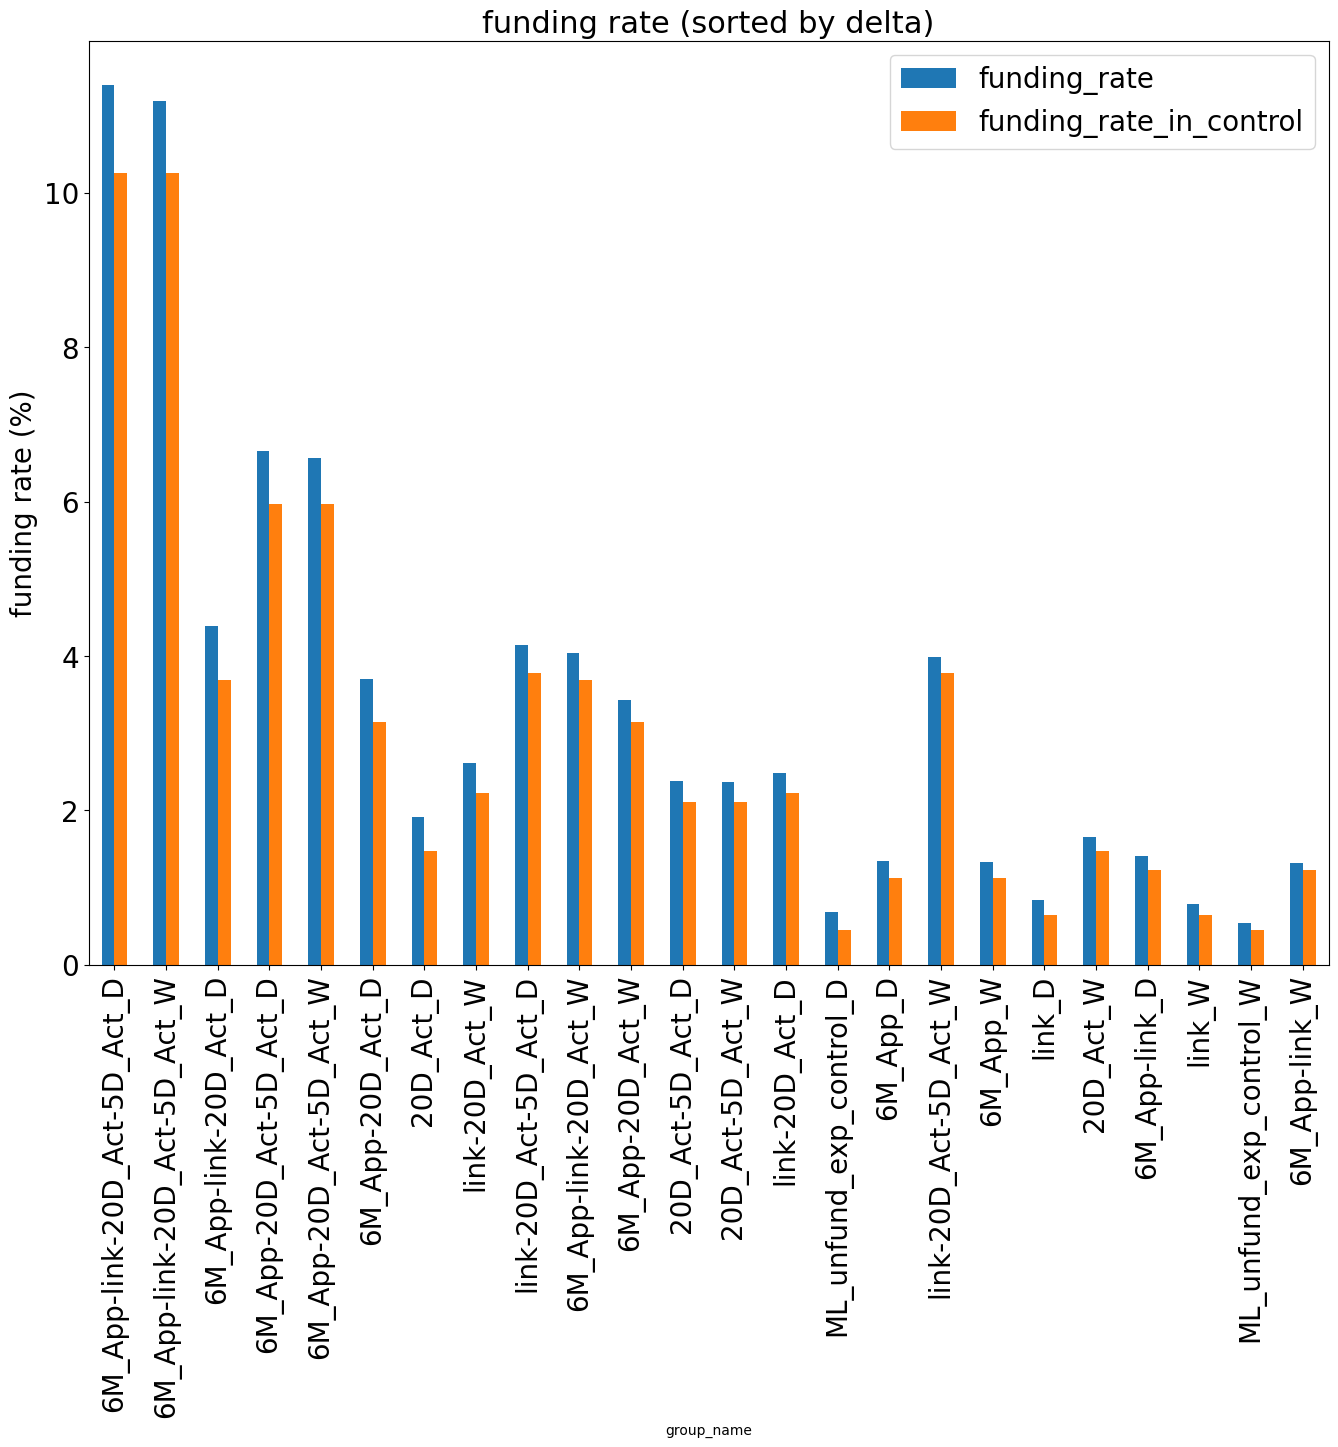

In [31]:
ax = temp.plot(x="group_name", y=["funding_rate", "funding_rate_in_control"], kind="bar",figsize=(16, 12))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('funding rate (%)',fontsize=20)
plt.title('funding rate (sorted by delta)',fontsize=22)
    
plt.legend(fontsize=20)
plt.grid(b=True, which='both', color='0.65', linestyle='-')

ax2=ax.twinx()
ax2.plot(temp['group_name'], temp['delta_fund_rate'],color="green",marker="o")

ax2.set_ylabel('size')
plt.yticks(fontsize=20)
plt.ylabel('delta funding rate (%)',fontsize=20)

plt.show()

In [32]:
temp =exp_funding_merge_df[exp_funding_merge_df['link_rate']<1].sort_values('delta_link_rate',ascending=False)
temp[["link_rate", "link_rate_in_control",'delta_link_rate']] = temp[["link_rate", "link_rate_in_control",'delta_link_rate']]*100

ValueError: ignored

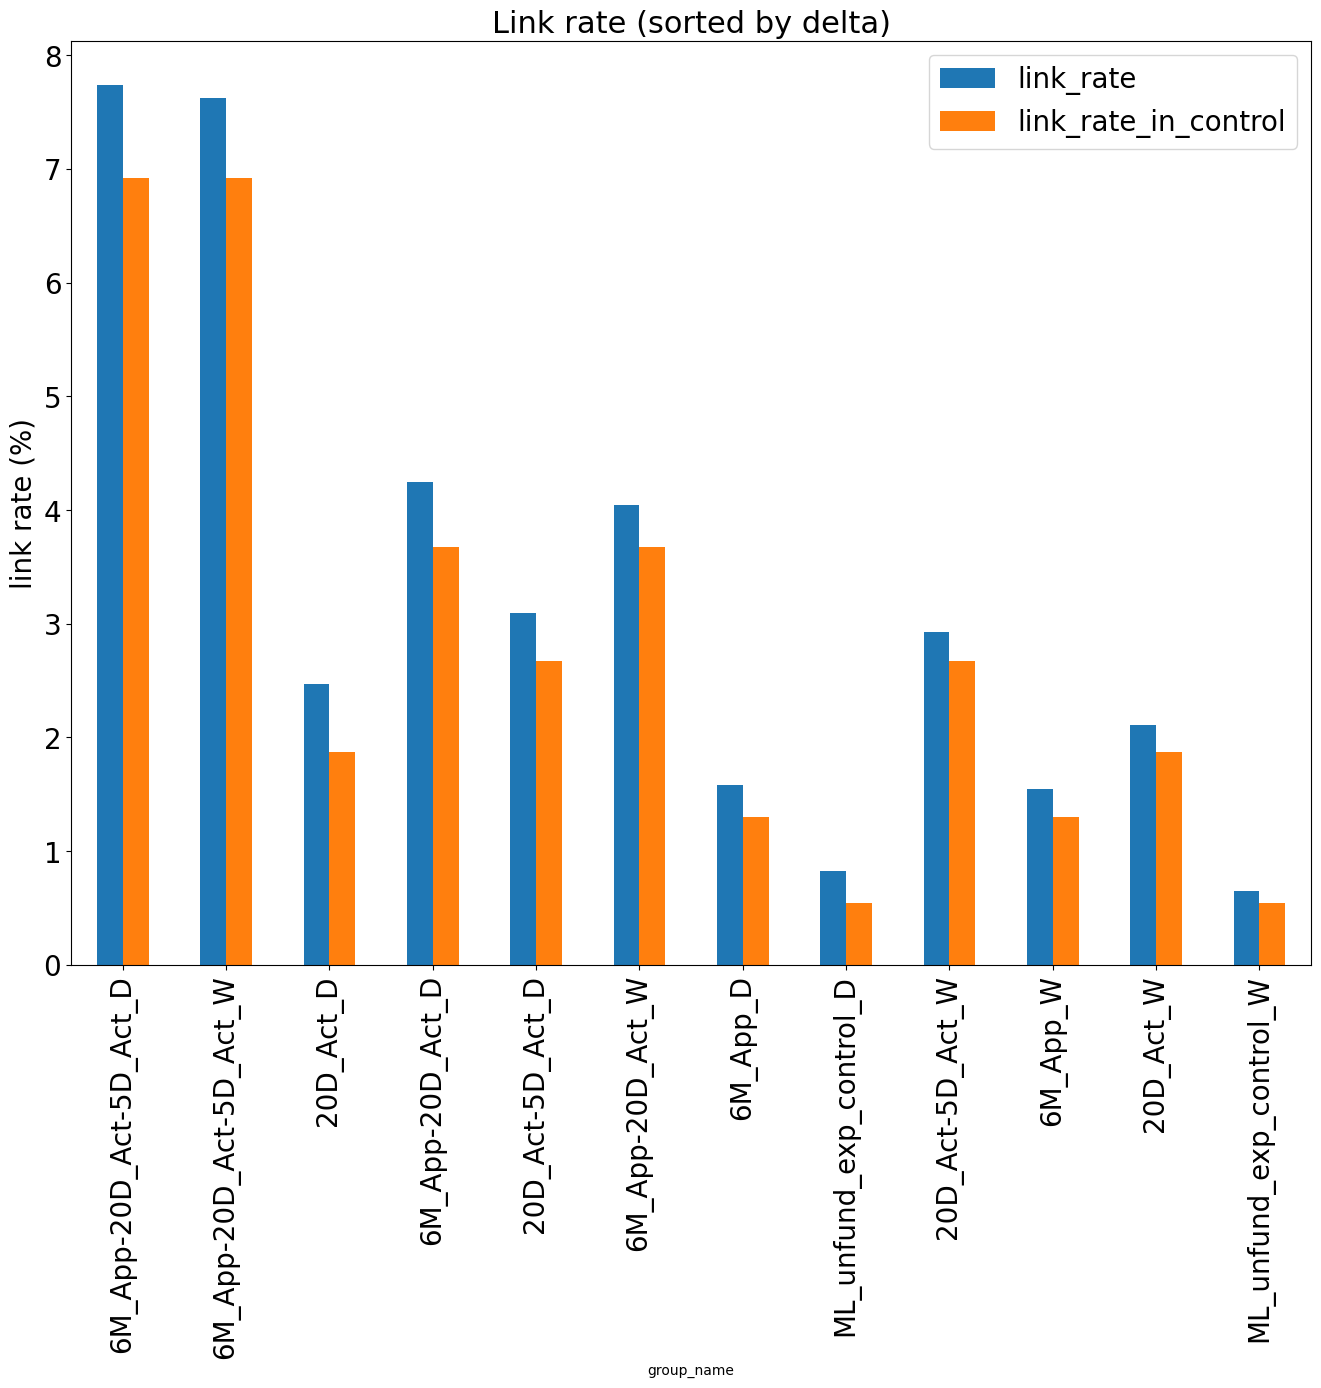

In [33]:
ax = temp.plot(x="group_name", y=["link_rate", "link_rate_in_control"], kind="bar",figsize=(16, 12))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('link rate (%)',fontsize=20)
plt.title('Link rate (sorted by delta)',fontsize=22)
    
plt.legend(fontsize=20)
plt.grid(b=True, which='both', color='0.65', linestyle='-')

ax2=ax.twinx()
ax2.plot(temp['group_name'], temp['delta_link_rate'],color="green",marker="o")

#ax = temp['delta_fund_rate'].plot(secondary_y=True, color='k', marker='o',figsize=(16, 12))
ax2.set_ylabel('size')
plt.yticks(fontsize=20)
plt.ylabel('delta link rate (%)',fontsize=20)

plt.show()

# Calculate Time series Metrics


## 1. Pivot email event table to time series (delivery order_0, _1, ..., _9)

In [34]:
email_date_df = user_event_df[['user_uuid','group_name']+PO_number_list]
email_date_df.head()

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
PO_number_dict = {}
for d in range(len(PO_number_list)):
    PO_number_dict[d] = PO_number_list[d]

In [36]:
email_event_name_df = sample_exp_df.copy()
for d in range(len(PO_number_list)):
    email_event_name_df['order_'+str(d)] = email_event_name_df['order_'+str(d)].map(PO_number_dict)

email_event_name_df.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,ml_funding_is_safe,ml_investing_101,ml_funding_faq,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_explore_the_app_list,ml_funding_enables_investing,ml_investing_starts_here,ml_picking_an_investment,ml_explore_the_app_investing
1,id_14752263936159847779,0,ML_unfund_exp_control_D,ml_funding_faq,ml_investing_starts_here,ml_picking_an_investment,ml_funding_enables_investing,ml_funding_is_safe,ml_explore_the_app_list,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_investing_101,ml_explore_the_app_investing
2,id_3723259155072282145,0,ML_unfund_exp_control_D,ml_diversified_portfolio,ml_investing_101,ml_funding_faq,ml_picking_an_investment,ml_investing_starts_here,ml_user_clustering_emails_fracs,ml_explore_the_app_investing,ml_explore_the_app_list,ml_funding_enables_investing,ml_funding_is_safe
3,id_9433964625840258739,0,ML_unfund_exp_control_D,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_picking_an_investment,ml_funding_is_safe,ml_investing_101,ml_user_clustering_emails_fracs,ml_explore_the_app_list,ml_funding_faq,ml_explore_the_app_investing
4,id_17251718038176858460,0,ML_unfund_exp_control_D,ml_picking_an_investment,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_investing_101,ml_funding_faq,ml_funding_is_safe,ml_explore_the_app_investing,ml_explore_the_app_list,ml_user_clustering_emails_fracs


In [37]:
big_table_df = email_event_name_df.merge(email_date_df.drop(columns = ['group_name']),on='user_uuid', how = 'left')
big_table_df.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
0,id_2623238174270264636,0,ML_unfund_exp_control_D,ml_funding_is_safe,ml_investing_101,ml_funding_faq,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_explore_the_app_list,ml_funding_enables_investing,ml_investing_starts_here,ml_picking_an_investment,ml_explore_the_app_investing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id_14752263936159847779,0,ML_unfund_exp_control_D,ml_funding_faq,ml_investing_starts_here,ml_picking_an_investment,ml_funding_enables_investing,ml_funding_is_safe,ml_explore_the_app_list,ml_user_clustering_emails_fracs,ml_diversified_portfolio,ml_investing_101,ml_explore_the_app_investing,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered
2,id_3723259155072282145,0,ML_unfund_exp_control_D,ml_diversified_portfolio,ml_investing_101,ml_funding_faq,ml_picking_an_investment,ml_investing_starts_here,ml_user_clustering_emails_fracs,ml_explore_the_app_investing,ml_explore_the_app_list,ml_funding_enables_investing,ml_funding_is_safe,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open
3,id_9433964625840258739,0,ML_unfund_exp_control_D,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_picking_an_investment,ml_funding_is_safe,ml_investing_101,ml_user_clustering_emails_fracs,ml_explore_the_app_list,ml_funding_faq,ml_explore_the_app_investing,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,id_17251718038176858460,0,ML_unfund_exp_control_D,ml_picking_an_investment,ml_investing_starts_here,ml_diversified_portfolio,ml_funding_enables_investing,ml_investing_101,ml_funding_faq,ml_funding_is_safe,ml_explore_the_app_investing,ml_explore_the_app_list,ml_user_clustering_emails_fracs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
def update_event(in_df):    
    out_df = in_df[['user_uuid','group_name']]
    for d in range(10):
        out_df['order_' + str(d)] = in_df[in_df['order_'+str(d)]]
    return out_df

In [39]:
import time
tic = time.clock()

email_event_TS_df = big_table_df.apply(update_event,axis=1)

toc = time.clock()
print('run time:' + str(toc - tic))

AttributeError: ignored

In [ ]:
import time

tic = time.perf_counter()

email_event_TS_df = big_table_df.apply(update_event,axis=1)

toc = time.perf_counter()
print('run time:' + str(toc - tic))


run time:2173.095670442


In [ ]:
email_event_TS_df.head()

,user_uuid,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered,delivered
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,delivered,delivered,open,open,open,delivered,delivered
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
email_event_TS_df.to_csv('/content/drive/MyDrive/Email_project/email_event_TS.csv')

OSError: ignored

In [ ]:
day_list = []
for i in range(len(PO_number_list)):
    day_list.append('order_' + str(i))

#delivered_count_df = user_event_df.drop(columns=['user_uuid'])
delivered_count_TS_df = email_event_TS_df[['user_uuid','group_name']+day_list]
for e in day_list:
    delivered_count_TS_df[e] = delivered_count_TS_df[e].notnull()
    
delivered_count_TS_df = delivered_count_TS_df.groupby('group_name').sum().reset_index()

In [ ]:
delivered_count_TS_df.head()

## 2. Check if the experiment has finished.

Apparently, the experiment is no finished as the '*_W' users have not received their last Email (order_9) yet.

In [ ]:

result = delivered_count_TS_df[delivered_count_TS_df['group_name'].str.contains('_D')].set_index('group_name')
result = delivered_count_TS_df.set_index('group_name')
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Heatmap of Email delivered number (time series)',fontsize=22)
    
    
plt.show()

In [ ]:
#open_count_df = user_event_df.drop(columns=['user_uuid'])
open_count_TS_df = email_event_TS_df[['user_uuid','group_name']+day_list]
for e in day_list:
    open_count_TS_df[e] = open_count_TS_df[e] == 'open' 
    
open_count_TS_df = open_count_TS_df.groupby('group_name').sum().reset_index()
open_count_TS_df.head()

In [ ]:
open_rate_TS_df = open_count_TS_df
for e in day_list:
    open_rate_TS_df[e] = open_count_TS_df[e]/delivered_count_TS_df[e]

## 3. Check heatmap for Email open rate according to the order they were sent.

One possible strategy for future Email experiment is to send 2-3 Emails, as the second Email intents to have a higher open rate.

In [ ]:
result = open_rate_TS_df[open_rate_TS_df['group_name'].str.contains('_D')].set_index('group_name')
# uncomment after the experiment finishes
result = open_rate_TS_df.set_index('group_name')
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Heatmap of Email open rate (time series)',fontsize=22)
    
    
plt.show()

# Optional: Funnel analysis

In [ ]:
rate_funnel_df = exp_funding_merge_df[['group_name','link_rate','act_rate','funding_rate','link_rate_in_control',
                                       'funding_rate_in_control','delta_link_rate','delta_fund_rate']]
rate_funnel_df['max_Email_open_rate'] = open_rate_TS_df.max(axis=1)
rate_funnel_df['delta_rate_funnel'] = rate_funnel_df['max_Email_open_rate'] - rate_funnel_df['funding_rate']
rate_funnel_df['extra_conversion_rate'] = rate_funnel_df['delta_fund_rate'] / rate_funnel_df['max_Email_open_rate'] 
rate_funnel_df.head()

In [ ]:
#temp =rate_funnel_df#[rate_funnel_df['link_rate']<1].sort_values('delta_link_rate',ascending=False)
temp =rate_funnel_df.sort_values('delta_fund_rate',ascending=False)

num_list = temp.select_dtypes(include=np.number).columns.tolist()
temp[num_list] = temp[num_list]*100

ax = temp.plot(x="group_name", y=["max_Email_open_rate", "link_rate", "funding_rate"], kind="bar",figsize=(16, 12))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Rate (%)',fontsize=20)
plt.title('Email Open Rate -> Link Rate -> Funding Rate (sorted by delta funding rate)',fontsize=22)
    
plt.legend(fontsize=20)
plt.grid(b=True, which='both', color='0.65', linestyle='-')

ax2=ax.twinx()
ax2.plot(temp['group_name'], temp['delta_fund_rate'],color="green",marker="o")

#ax = temp['delta_fund_rate'].plot(secondary_y=True, color='k', marker='o',figsize=(16, 12))
ax2.set_ylabel('size')
plt.yticks(fontsize=20)
plt.ylabel('delta funding rate (%)',fontsize=20)

plt.show()

In [ ]:
#temp =rate_funnel_df#[rate_funnel_df['link_rate']<1].sort_values('delta_link_rate',ascending=False)
temp =rate_funnel_df.sort_values('extra_conversion_rate',ascending=False)

num_list = temp.select_dtypes(include=np.number).columns.tolist()
temp[num_list] = temp[num_list]*100

ax = temp.plot(x="group_name", y=["max_Email_open_rate", "funding_rate","funding_rate_in_control"], kind="bar",figsize=(16, 12))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Rate (%)',fontsize=20)
plt.title('Email Open Rate -> Funding Rate (sorted by extra conversion rate)',fontsize=22)
    
plt.legend(fontsize=20)
plt.grid(b=True, which='both', color='0.65', linestyle='-')

ax2=ax.twinx()
ax2.plot(temp['group_name'], temp['extra_conversion_rate'],color="green",marker="o")

#ax = temp['delta_fund_rate'].plot(secondary_y=True, color='k', marker='o',figsize=(16, 12))
ax2.set_ylabel('size')
plt.yticks(fontsize=20)
plt.ylabel('extra conversion rate (%)',fontsize=20)

plt.show()

In [ ]:
#temp =rate_funnel_df#[rate_funnel_df['link_rate']<1].sort_values('delta_link_rate',ascending=False)
temp =rate_funnel_df.sort_values('delta_rate_funnel')#,ascending=False)

num_list = temp.select_dtypes(include=np.number).columns.tolist()
temp[num_list] = temp[num_list]*100

ax = temp.plot(x="group_name", y=["max_Email_open_rate", "funding_rate","funding_rate_in_control"], kind="bar",figsize=(16, 12))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Rate (%)',fontsize=20)
plt.title('Email Open Rate -> Funding Rate (sorted by funnel delta)',fontsize=22)
    
plt.legend(fontsize=20)
plt.grid(b=True, which='both', color='0.65', linestyle='-')

ax2=ax.twinx()
ax2.plot(temp['group_name'], temp['delta_rate_funnel'],color="green",marker="o")

#ax = temp['delta_fund_rate'].plot(secondary_y=True, color='k', marker='o',figsize=(16, 12))
ax2.set_ylabel('size')
plt.yticks(fontsize=20)
plt.ylabel('funnel delta (%)',fontsize=20)

plt.show()